In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
EPOCHS = 1000

In [3]:
tf.__version__

'1.10.0'

## MPG Dataset

Get the dataset

In [4]:
dataset_path = keras.utils.get_file(
    "auto-mpg.data",
    "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
)
dataset_path

'/home/ec2-user/.keras/datasets/auto-mpg.data'

In [5]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight', 'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, comment="\t", na_values="?", names=column_names, sep=" ", skipinitialspace=True)

# make a copy
dataset = raw_dataset.copy()
dataset.sample(5)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
301,34.2,4,105.0,70.0,2200.0,13.2,79,1
225,17.5,6,250.0,110.0,3520.0,16.4,77,1
20,25.0,4,110.0,87.0,2672.0,17.5,70,2
333,32.7,6,168.0,132.0,2910.0,11.4,80,3
271,23.2,4,156.0,105.0,2745.0,16.7,78,1


### Cleaning Dataset

Remove NA values.

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
dataset = dataset.dropna()

In [8]:
# convert origin to one-hot attributes
origin = dataset.pop('Origin')
origin.sample(5)

253    1
227    1
29     3
320    3
271    1
Name: Origin, dtype: int64

In [9]:
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset.sample(5)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
346,32.3,4,97.0,67.0,2065.0,17.8,81,0.0,0.0,1.0
53,31.0,4,71.0,65.0,1773.0,19.0,71,0.0,0.0,1.0
68,13.0,8,350.0,155.0,4502.0,13.5,72,1.0,0.0,0.0
367,28.0,4,112.0,88.0,2605.0,19.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0


### Split Data

Need training and testing data sets.

In [10]:
train_dataset = dataset.sample(frac=0.8)
test_dataset = dataset.drop(train_dataset.index)

### Inspect Data

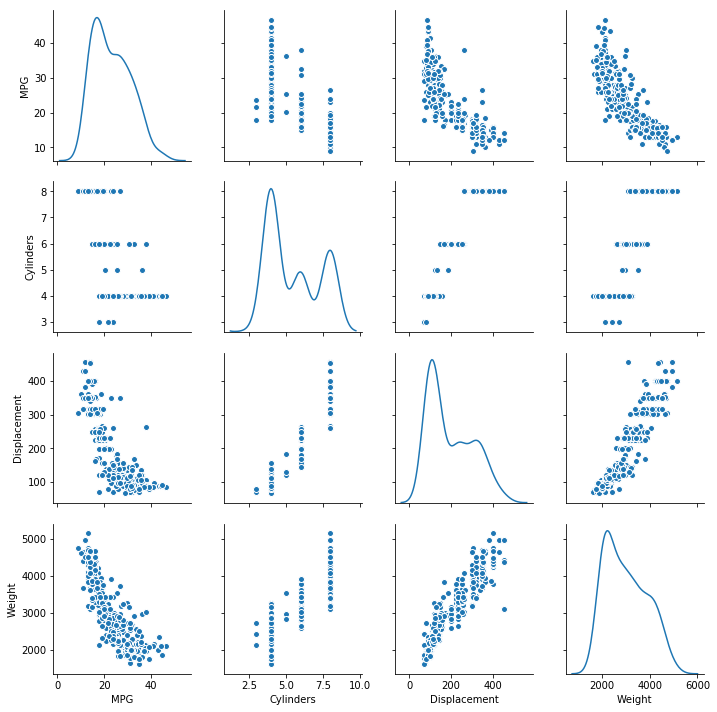

In [11]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind='kde')

In [12]:
train_stats = train_dataset.describe()
train_stats

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,23.378344,5.541401,198.162420,105.541401,3011.035032,15.481210,75.920382,0.627389,0.175159,0.197452
std,7.993866,1.732938,105.754564,38.985373,860.737674,2.757284,3.714667,0.484272,0.380710,0.398712
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,16.625000,4.000000,105.000000,75.000000,2223.750000,13.500000,73.000000,0.000000,0.000000,0.000000
50%,22.150000,4.000000,151.000000,95.000000,2902.500000,15.500000,76.000000,1.000000,0.000000,0.000000
75%,29.725000,8.000000,302.000000,130.000000,3687.750000,17.000000,79.000000,1.000000,0.000000,0.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


In [13]:
# keep track of transposed train_stats to normalize
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.378344,7.993866,9.0,16.625,22.15,29.725,46.6
Cylinders,314.0,5.541401,1.732938,3.0,4.000,4.00,8.000,8.0
Displacement,314.0,198.162420,105.754564,68.0,105.000,151.00,302.000,455.0
Horsepower,314.0,105.541401,38.985373,46.0,75.000,95.00,130.000,230.0
Weight,314.0,3011.035032,860.737674,1613.0,2223.750,2902.50,3687.750,5140.0
Acceleration,314.0,15.481210,2.757284,8.0,13.500,15.50,17.000,24.8
Model Year,314.0,75.920382,3.714667,70.0,73.000,76.00,79.000,82.0
USA,314.0,0.627389,0.484272,0.0,0.000,1.00,1.000,1.0
Europe,314.0,0.175159,0.380710,0.0,0.000,0.00,0.000,1.0
Japan,314.0,0.197452,0.398712,0.0,0.000,0.00,0.000,1.0


### Isolate Labels

Separate labels (the target values) from the data.

In [14]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalize Data

In [15]:
def normalize(df):
    return (df - train_stats['mean']) / train_stats['std']

In [16]:
normed_train_dataset = normalize(train_dataset)
normed_test_dataset = normalize(test_dataset)

normed_train_dataset.pop("MPG")
normed_test_dataset.pop("MPG")

normed_train_dataset.sample(5)

,Acceleration,Cylinders,Displacement,Europe,Horsepower,Japan,Model Year,USA,Weight
62,-1.262550,1.418746,1.435754,-0.460086,1.525151,-0.495225,-1.055379,0.769427,1.467305
207,0.079350,-0.889473,-0.644534,2.166586,-0.090839,-0.495225,0.021433,-1.295530,0.161449
253,0.986039,0.264637,0.017376,-0.460086,-0.270394,-0.495225,0.559840,0.769427,0.167258
209,2.327939,-0.889473,-0.739093,2.166586,-0.449948,-0.495225,0.021433,-1.295530,0.300864
98,0.913504,0.264637,0.490169,-0.460086,-0.142141,-0.495225,-0.786176,0.769427,0.310158


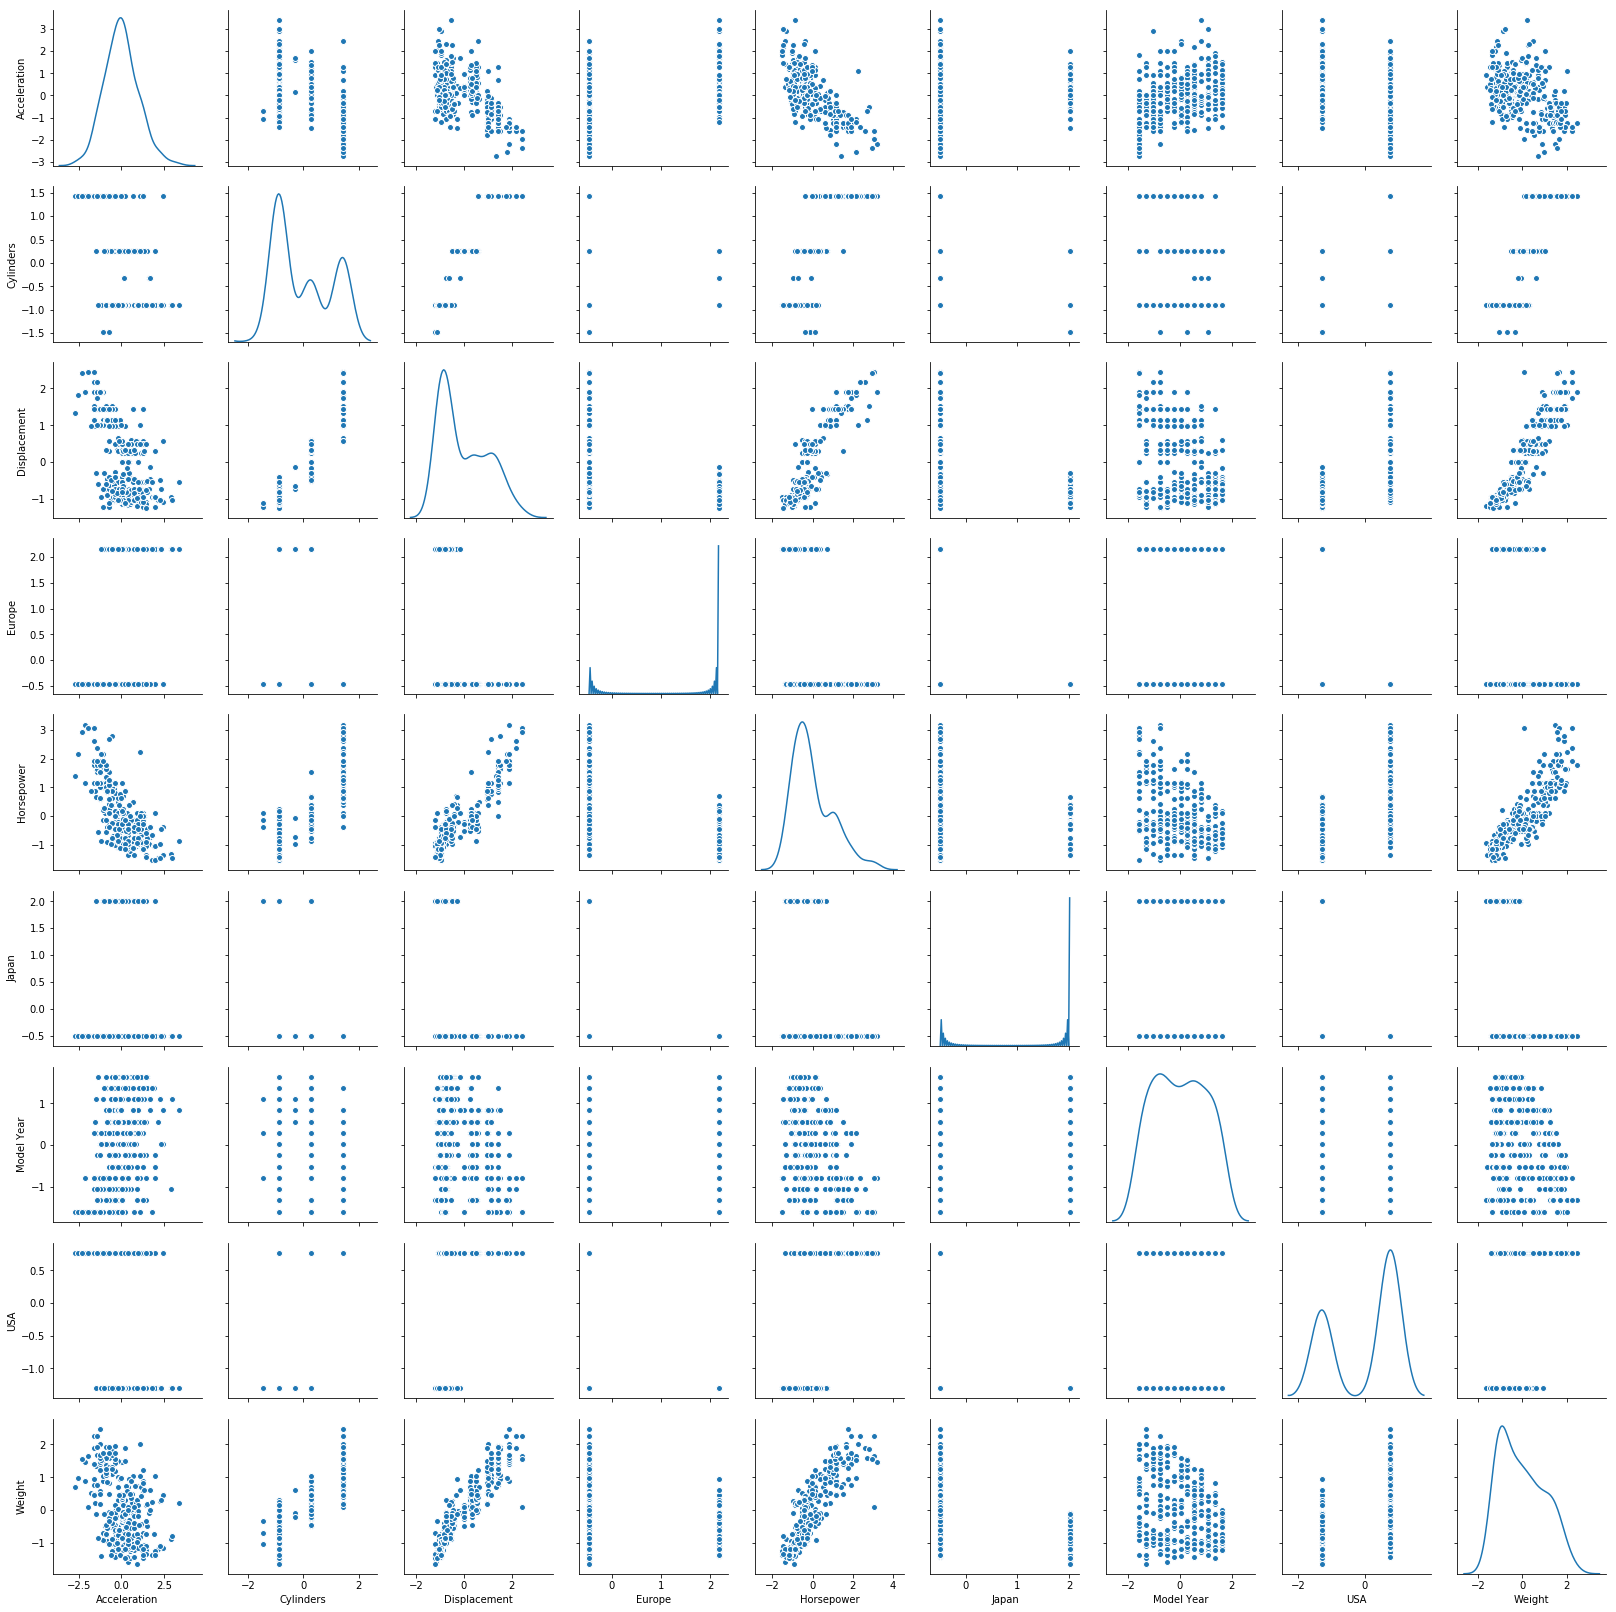

In [17]:
sns.pairplot(normed_train_dataset, diag_kind='kde')

## The Model

In [18]:
# wrap model creation in function
def build_model():
    
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    
    optimizer = tf.train.RMSPropOptimizer(0.001)
    model.compile(
        loss='mse',
        metrics=['mae', 'mse'],
        optimizer=optimizer
    )
    
    return model

In [19]:
model = build_model()

### Inspect Model

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [21]:
# try model on tiny input
example_batch = normed_train_dataset.sample(10)
example_result = model.predict(example_batch)
example_result

array([[-0.37396508],
       [-0.04217114],
       [-0.39269978],
       [-0.2500349 ],
       [-0.09615049],
       [-0.24209902],
       [-0.0634995 ],
       [-0.3247141 ],
       [-0.28231606],
       [-0.20081678]], dtype=float32)

### Train Model

In [22]:
# callback subclass for feedback
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if (epoch % 100 == 0):
            print('')
        print('.', end="")

In [23]:
# track history for inspection later
history = model.fit(normed_train_dataset, train_labels, callbacks=[PrintDot()], epochs=EPOCHS, validation_split=0.2, verbose=0)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [24]:
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = history.epoch
hist_df.sample(5).sort_values(by='epoch')

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
196,4.676825,1.533916,4.676825,7.885128,1.907621,7.885128,196
264,4.131760,1.417481,4.131760,8.791544,2.031481,8.791544,264
358,3.615510,1.321461,3.615510,8.390448,2.046748,8.390448,358
436,3.513190,1.259800,3.513190,9.029665,2.113002,9.029665,436
686,2.528365,1.075812,2.528365,9.991816,2.217177,9.991816,686


In [25]:
def plot_history(history, hist_df):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Absolute Error [MPG]")
    plt.plot(hist_df['epoch'], hist_df['mean_absolute_error'], label="Train Error")
    plt.plot(hist_df['epoch'], hist_df['val_mean_absolute_error'], label="Validation Error")
    plt.legend()
    plt.ylim([0, 5])
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Square Error [$MPG^2$]")
    plt.plot(hist_df['epoch'], hist_df['mean_squared_error'], label="Train Error")
    plt.plot(hist_df['epoch'], hist_df['val_mean_squared_error'], label="Validation Error")
    plt.legend()
    plt.ylim([0, 20])

Plot history and note the diminishing returns.

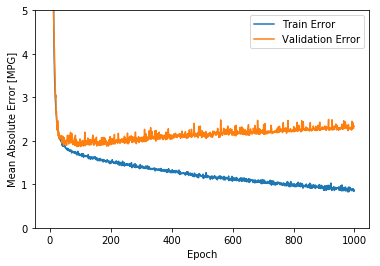

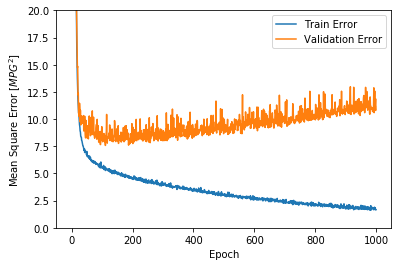

In [26]:
plot_history(history, hist_df)

In [27]:
# use a callback to do early stopping for better results
model = build_model()

early_stop_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=50)

history = model.fit(normed_train_dataset, train_labels, callbacks=[early_stop_cb, PrintDot()], epochs=EPOCHS, validation_split=0.2,
    verbose=0)


....................................................................................................
...........................................

In [28]:
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = history.epoch
hist_df.sample(5).sort_values(by='epoch')

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
34,7.816183,1.998822,7.816183,10.902557,2.234479,10.902557,34
42,7.278336,1.900128,7.278336,9.722273,2.091307,9.722273,42
43,7.056827,1.878696,7.056827,10.324271,2.145411,10.324271,43
83,5.969953,1.735194,5.969953,10.110568,2.167606,10.110568,83
134,5.323788,1.628941,5.323788,8.765654,1.998878,8.765654,134


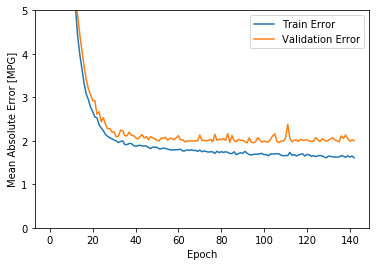

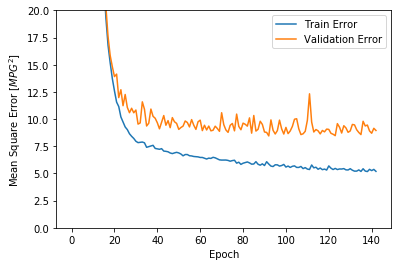

In [29]:
plot_history(history, hist_df)

Test model against test data.

In [30]:
loss, mae, mse = model.evaluate(normed_test_dataset, test_labels, verbose=0)

In [31]:
print("Testing MAE: {:5.2f}".format(mae))

Testing MAE:  2.00


### Make Predictions

In [32]:
test_predictions = model.predict(normed_test_dataset).flatten()

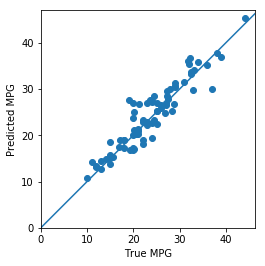

In [33]:
plt.scatter(test_labels, test_predictions)
plt.xlabel("True MPG")
plt.ylabel("Predicted MPG")
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

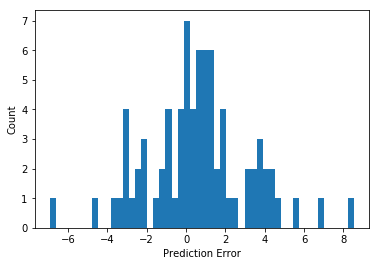

In [34]:
error = test_predictions - test_labels
plt.hist(error, bins=50)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
_ = plt.plot()